In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import torch
import time
import pickle
import seaborn as sns
import scipy.stats
import scipy

In [2]:
import matplotlib.pyplot as plt

SMALL_SIZE =  10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [3]:
sys.path.append('/global/u2/v/vboehm/codes/SIG_GIS/')
from sig_gis import *
from sig_gis.GIS import *

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
classes = {2:'GAL', 1:'QSO', 0:'STAR'}

In [6]:
plotpath = '/global/homes/v/vboehm/codes/SDSS_PAE/figures'

In [7]:
RUN             = '1'
EPOCHS          = 40

seeds           = {'1':512, '2':879, '3':9981, '4': 20075, '5': 66, '6': 276, '7': 936664}

conditional     = False
cond_on         = 'type'

root_model_data = '/global/cscratch1/sd/vboehm/Datasets/sdss/by_model/'
root_models     = '/global/cscratch1/sd/vboehm/Models/SDSS_AE/'
root_encoded    = '/global/cscratch1/sd/vboehm/Datasets/encoded/sdss/'
root_decoded    = '/global/cscratch1/sd/vboehm/Datasets/decoded/sdss/'


wlmin, wlmax    = (3388,8318)
fixed_num_bins  = 1000
min_SN          = 50
min_z           = 0.05
max_z           = 0.36
label           = 'galaxies_quasars_bins%d_wl%d-%d'%(fixed_num_bins,wlmin,wlmax)
label_          = label+'_minz%s_maxz%s_minSN%d'%(str(int(min_z*100)).zfill(3),str(int(max_z*100)).zfill(3),min_SN)
label_2         = label_+'_10_fully_connected_mean_div'

if conditional:
    label_2='conditional_%s'%cond_on+label_2

In [8]:
decoded = {}
masked  = {}

In [9]:
encoded_train, encoded_valid, encoded_test = np.load(os.path.join(root_encoded,'encoded_%s_RUN%s_new.npy'%(label_2,RUN)), allow_pickle=True)
decoded['train'],decoded['valid'], decoded['test'], mean, std  = np.load(os.path.join(root_decoded,'decoded_%s_RUN%s_new.npy'%(label_2,RUN)), allow_pickle=True)

In [10]:
train,valid,test,le = pickle.load(open(os.path.join(root_model_data,'combined_%s_new_labeled.pkl'%label_),'rb'))

In [11]:
len(train['spec']),len(test['spec'])

(209462, 69822)

In [12]:
train_x = torch.Tensor(np.squeeze(encoded_train)).to(device) 
valid_x = torch.Tensor(np.squeeze(encoded_valid)).to(device) 
test_x  = torch.Tensor(np.squeeze(encoded_test)).to(device) 

In [18]:
os.path.join(root_models,'conditional_SINF_%s_AE1'%(label_2))

'/global/cscratch1/sd/vboehm/Models/SDSS_AE/conditional_SINF_galaxies_quasars_bins1000_wl3388-8318_minz005_maxz036_minSN50_10_fully_connected_mean_div_AE1'

In [13]:
! ls -ltr '/global/cscratch1/sd/vboehm/Models/SDSS_AE/conditional_SINF_galaxies_quasars_bins1000_wl3388-8318_minz005_maxz036_minSN50_10_fully_connected_mean_div_AE1'

ModuleCmd_Load.c(244):ERROR:105: Unable to locate a modulefile for 'git'
-rw-rw---- 1 vboehm vboehm 64295251 Dec 20 13:52 /global/cscratch1/sd/vboehm/Models/SDSS_AE/conditional_SINF_galaxies_quasars_bins1000_wl3388-8318_minz005_maxz036_minSN50_10_fully_connected_mean_div_AE1


In [14]:
model = torch.load(os.path.join(root_models,'conditional_SINF_%s_AE1'%(label_2)))

In [15]:
train.keys()

dict_keys(['spec', 'mask', 'noise', 'z', 'RA', 'DEC', 'class', 'subclass', 'SN', 'MJD', 'plate', 'fiber', 'mean', 'std', 'labels', 'new_inf_labels'])

In [16]:
for data,dd  in zip([test_x],[test]):
    px = np.zeros((16,len(data)))
    for ii in range(16):
        px[ii]        = model.evaluate_density(data,ii*torch.ones((len(data))).to(device)).cpu().numpy()
    #px_marg           = px*prior[:, None]/np.sum(px*prior[:,None],axis=0)
    labels_new        = np.argmax(px,axis=0)
    new_logps         = px[labels_new,np.arange(len(labels_new))]
    # train_labels_marg = np.argmax(px_marg,axis=0)
    # train_marg_logps  = px[train_labels_marg,np.arange(len(train_labels_marg))]
    dd['new_label'] = labels_new
    dd['new_logp']  = px[labels_new,np.arange(len(labels_new))]
    dd['old_logp']  = px[np.asarray(dd['new_inf_labels'], dtype='int'),np.arange(len(labels_new))]

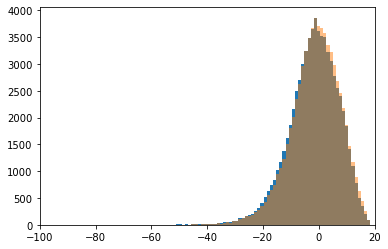

In [17]:
_ = plt.hist(dd['old_logp'],bins=400, range=(-400,50))
_ = plt.hist(dd['new_logp'],bins=400, range=(-400,50), alpha=0.5)
for jj in range(16):plt.xlim(-100,20)

In [18]:
for dd in [test]:
    dd['new_inf_labels'] = np.asarray(dd['new_inf_labels'], dtype=int)

In [19]:
trees = []
for jj in range(14):
    enc              = encoded_test[(test['new_label']==jj)&(test['new_inf_labels']==jj)]
    print(len(enc))
    trees.append(scipy.spatial.KDTree(enc))

29352
451
999
67
3709
4
14469
44
8
300
15
64
1
378


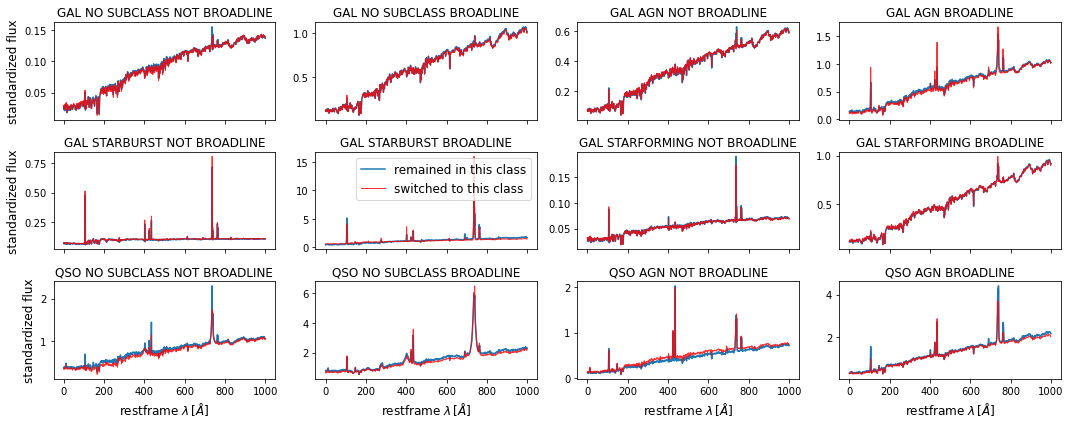

In [22]:
fi, ax = plt.subplots(3,4,figsize=(15,6),sharex=True)
ax = ax.flatten()
for jj in range(12):
    enc              = encoded_test[(test['new_inf_labels']!=jj)&(test['new_label']==jj)]
    dist, neighbors = trees[jj].query(enc, p=1)
    ind = np.argsort(dist)
    count = jj
    ax[count].set_title(le[jj])
    if jj ==5:
        ax[count].plot(decoded['test'][(test['new_inf_labels']==jj)&(test['new_label']==jj)][neighbors[ind[0]]], lw=1.5, label='remained in this class')
        ax[count].plot(decoded['test'][(test['new_inf_labels']!=jj)&(test['new_label']==jj)][ind[0]],label='switched to this class', lw=1., color='red', alpha=0.8)
        ax[count].legend()
    else:
        ax[count].plot(decoded['test'][(test['new_inf_labels']==jj)&(test['new_label']==jj)][neighbors[ind[0]]], lw=1.5)
        ax[count].plot(decoded['test'][(test['new_inf_labels']!=jj)&(test['new_label']==jj)][ind[0]], lw=1., color='red', alpha=0.8)
    if count%4==0:
        ax[count].set_ylabel('standardized flux')
    if count in [8,9,10,11]:
        ax[count].set_xlabel(r'restframe $\lambda\, [\AA]$')
    count+=1
plt.savefig(os.path.join(plotpath,'Figure7.pdf'),bbox_inches='tight')
plt.tight_layout()
plt.show()

In [23]:
len(np.where(test['new_inf_labels']!=test['new_label'])[0])/len(test['new_label'])

0.2855117298272751

In [24]:
#pickle.dump([train,valid,test,le],open(os.path.join(root_model_data,'combined_%s_new_relabeled.pkl'%label_),'wb'))

In [25]:
import sklearn.metrics as metrics

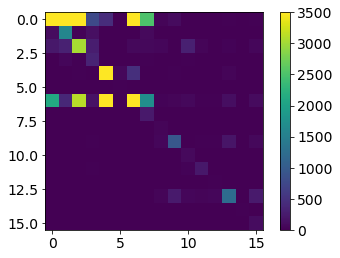

In [26]:
conf = metrics.confusion_matrix(train['new_inf_labels'], train['new_label'])
plt.imshow(conf, vmax=3500)
plt.colorbar()#, labels=le.inverse_transform(label))